# 0. Imports & inputs

In [1]:
# imports
import os
import sys
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import imageio
import datetime

# data file direcotry
data_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Data\Updated - New Sites\Site 4\ChartExport 10_05_2024 09_56 AM - Inv1 - String 1.csv"
# direrctory for saving results
base_dir = r"C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results"
# directory for LTspice text flie for STC
ltspice_dir_stc = r"C:\Users\z5183876\Documents\LTspice\24_10_06_mismatch_Baran\Site4_Module_STC.txt"
# directory for LTspice text flie for NOCT
ltspice_dir_noct = r"C:\Users\z5183876\Documents\LTspice\24_10_06_mismatch_Baran\Site4_Module_NOCT.txt"

# LTSpice IV parameter
# STC
il_stc = 8.706 # A
Rsh_stc = 240 # Ohms
Rs_stc = 5.03e-3 # Ohms
i0_stc = 2e-11 # A
n_stc = 0.902
# NOCT
il_noct = 7.026 # A
Rsh_noct = 240 # Ohms
Rs_noct = 5.7e-3 # Ohms
i0_noct = 1.1e-10 # A
n_noct = 0.905
# nuber of cells in series
N = 60

# Define constants for thermal voltage at 25°C
vth = 0.0258

# define the Vaxis for optimiser IV
Vaxis = np.linspace(0, 36, 100)

# define hte I axis for optimiser IV
Iaxis = np.linspace(0, 9, 100)

In [2]:
# define the function to calculate the I0 at MPPT
def I0(I, V, Rs, Rsh, n, N, vth):
    # calculate the exponential term
    exp_term = np.exp(-(V + I * Rs) / (n * N * vth))
    # calculate the fraction term
    frac_term = n * N * vth / V
    # calculate hte numerator
    numerator = I*(1 + Rs/Rsh) - V/Rsh
    # calculate the denominator
    denominator = 1 - I * Rs / V
    # put them together
    I0 = numerator / denominator * frac_term * exp_term
    return I0

# define the function to calculate IL at MPPT
def IL(I, V, Rs, Rsh, n, N, vth, I0):
    # calculate the first term
    first_term = I * (1 + Rs/Rsh)
    # calculate the second term
    second_term = V / Rsh
    # calculate the third term
    third_term = I0*(np.exp((V + I * Rs) / (n * N * vth)) - 1)
    # put them together
    IL = first_term + second_term + third_term
    return IL


# 1. Read & visualise

For Site 4 and Site 5 we have:
* Panel voltage
* Panel current
* Temperature
* Energy since last telem (Wh)
* Output Voltage
* Output Current
* Output Power

In [3]:
# read the data
df = pd.read_csv(data_dir)

# convert the time to datetime, look for column that contains the word "Time"
time_cols = [col for col in df.columns if 'Time' in col]
df[time_cols] = df[time_cols].apply(pd.to_datetime)

# count the number of columns that contains the word "Panel"
panel_cols = [col for col in df.columns if 'Panel' in col]

# read the Panel IDs from the panel_columns, they are the text after " - "
optimiser_ids = [col.split(" - ")[1] for col in panel_cols]


# 2. Calculate the power without mismatch

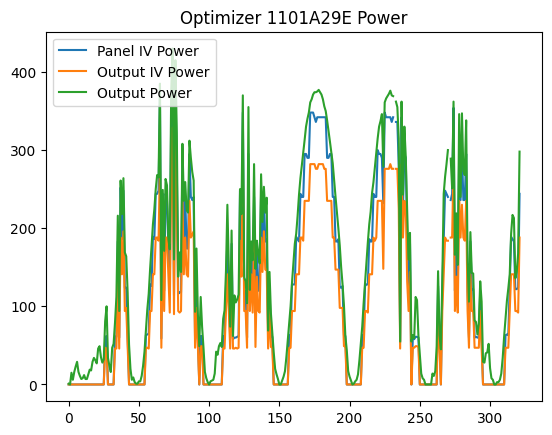

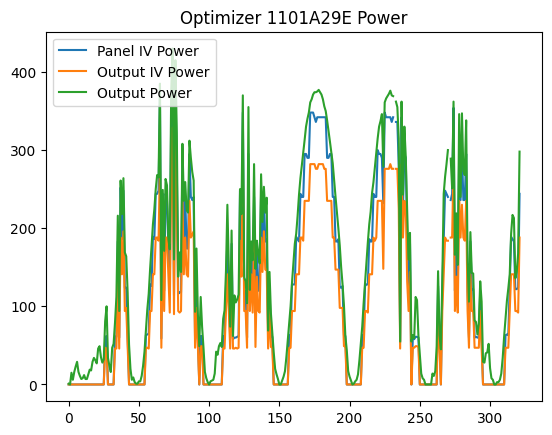

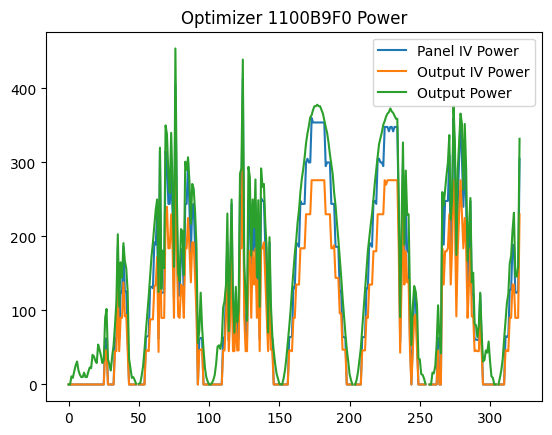

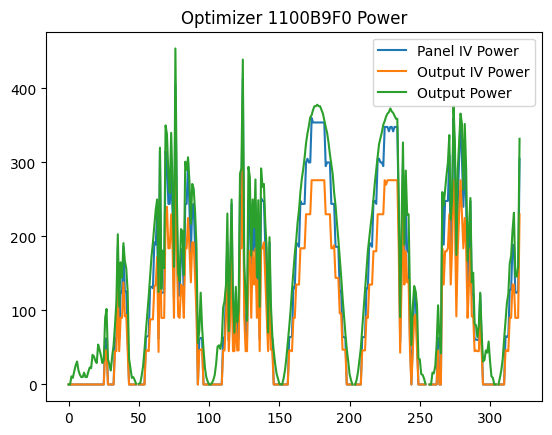

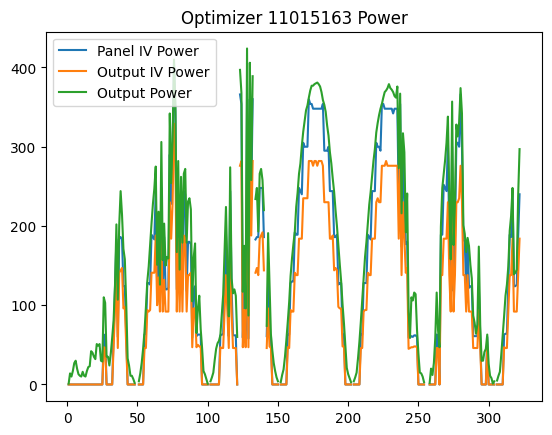

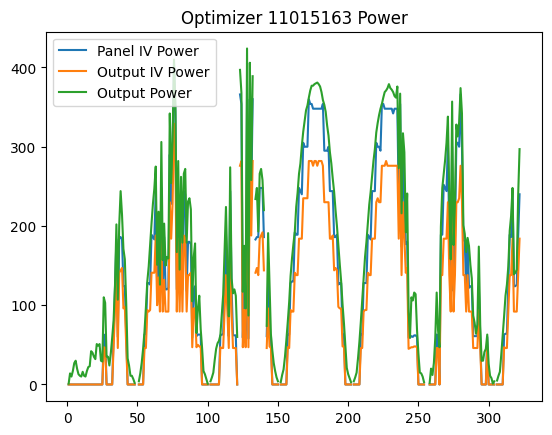

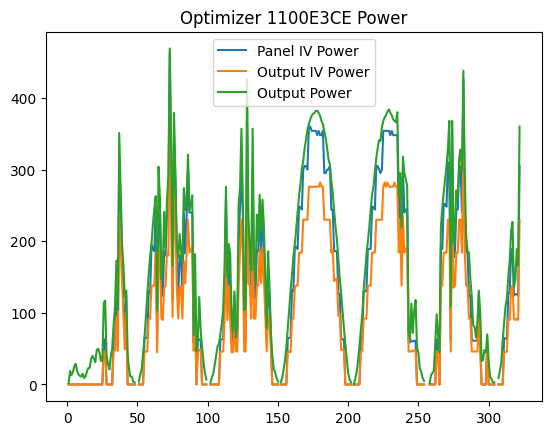

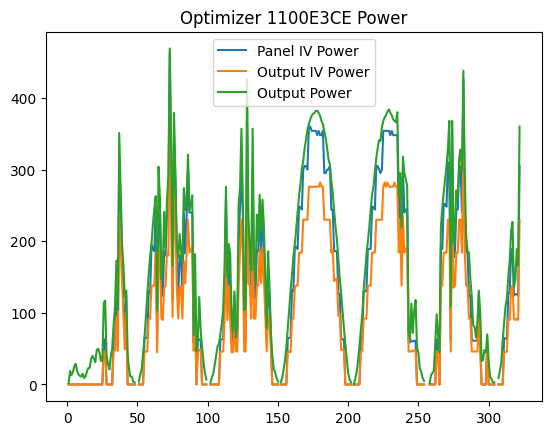

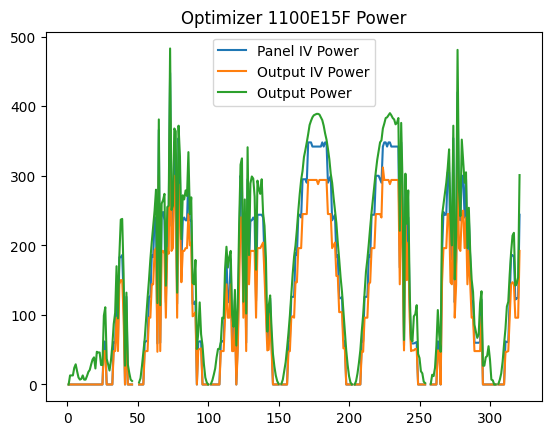

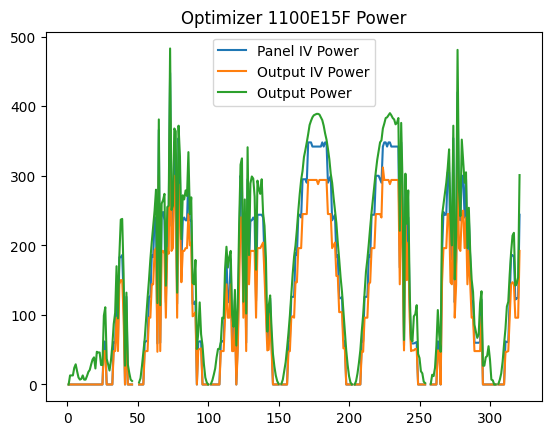

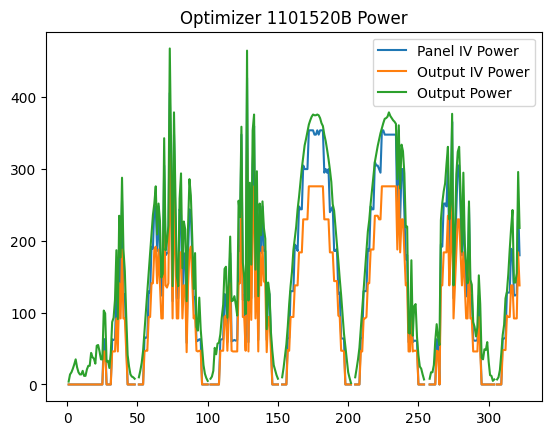

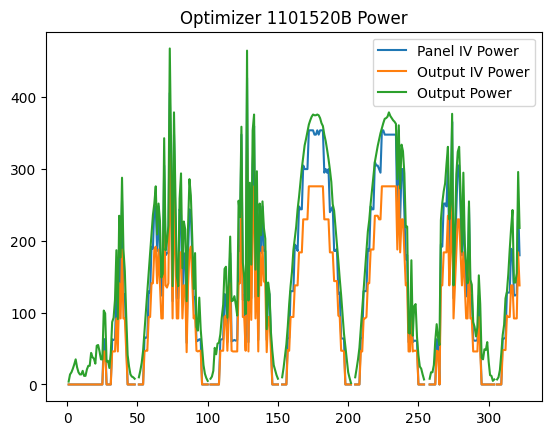

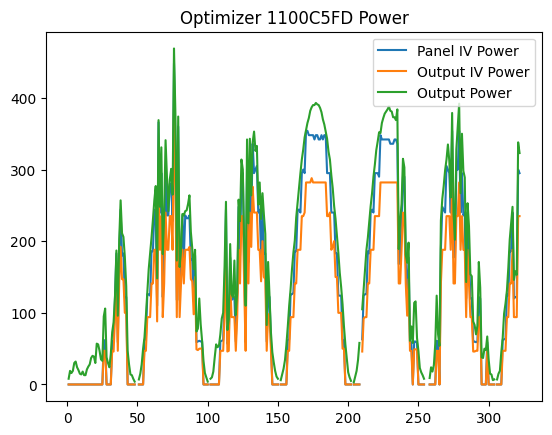

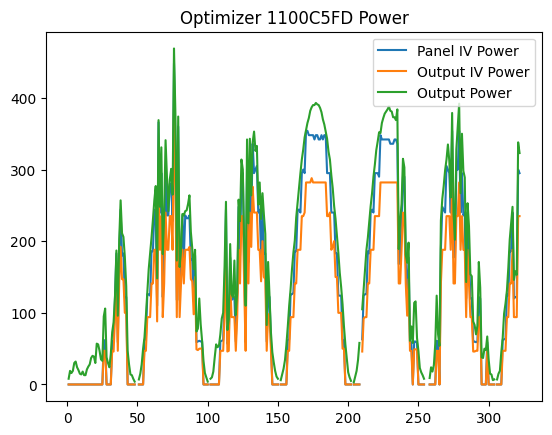

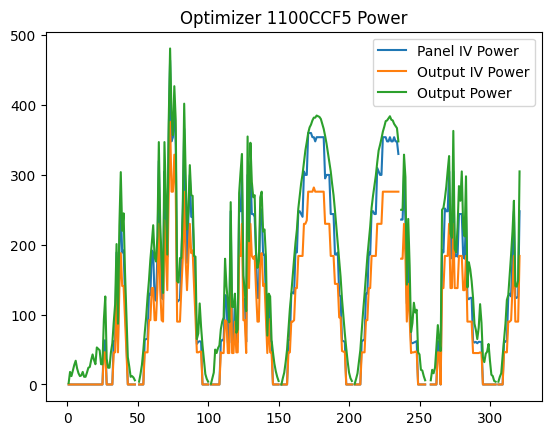

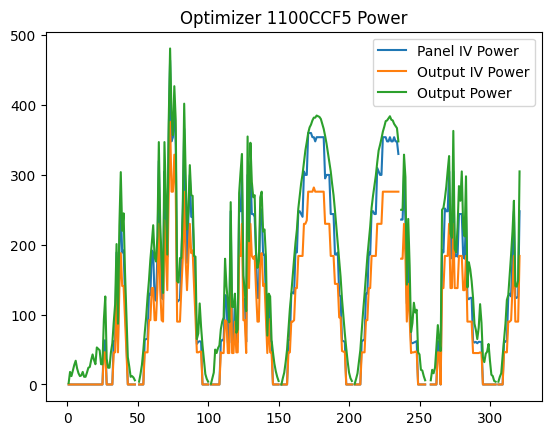

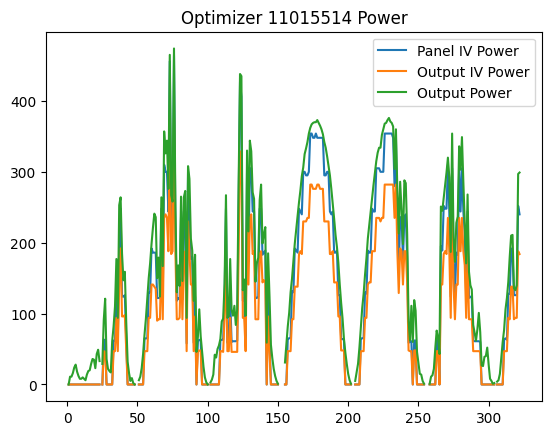

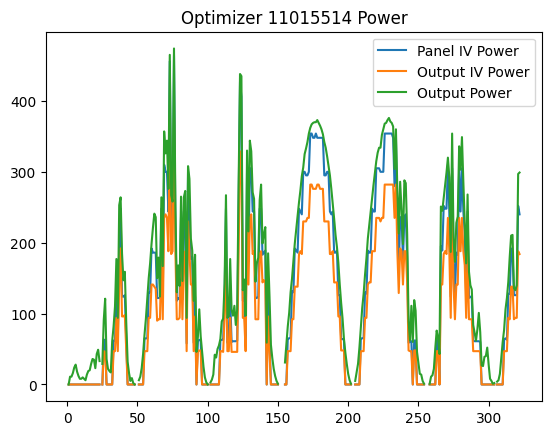

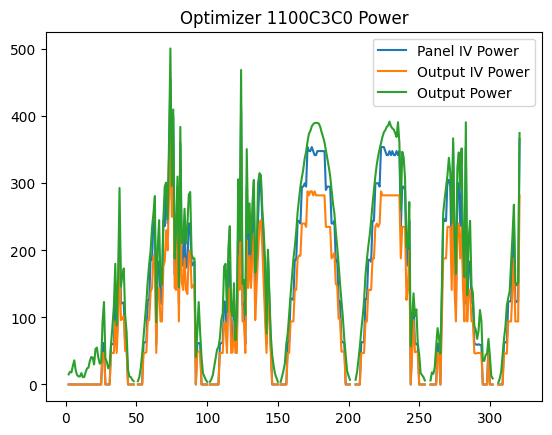

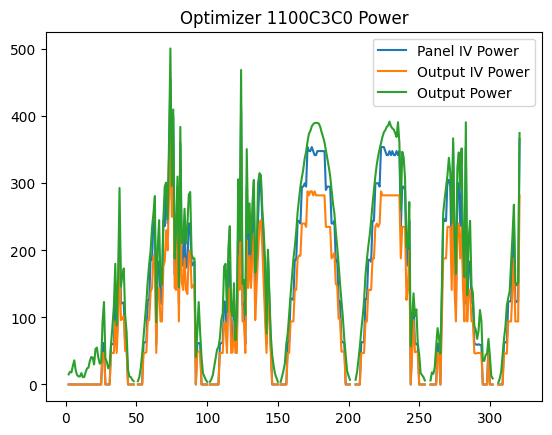

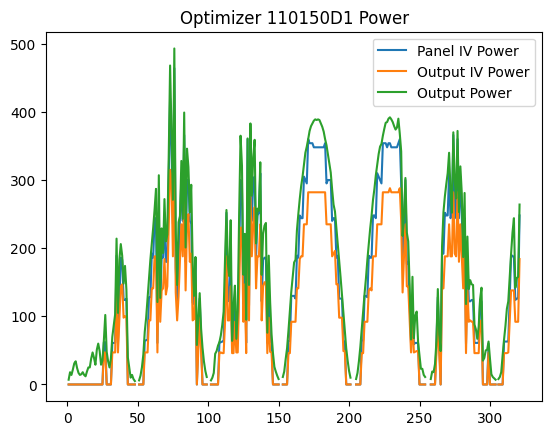

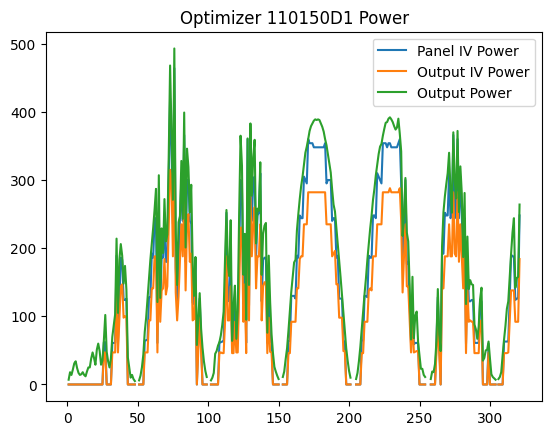

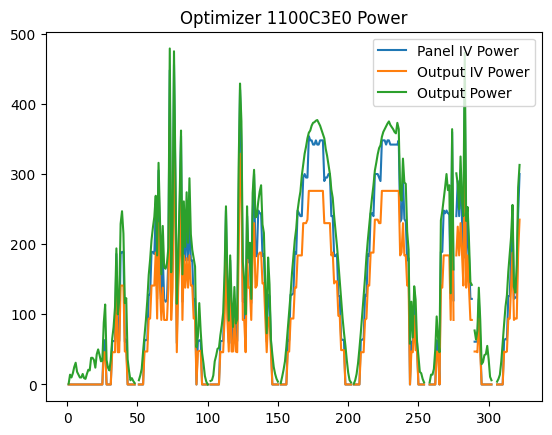

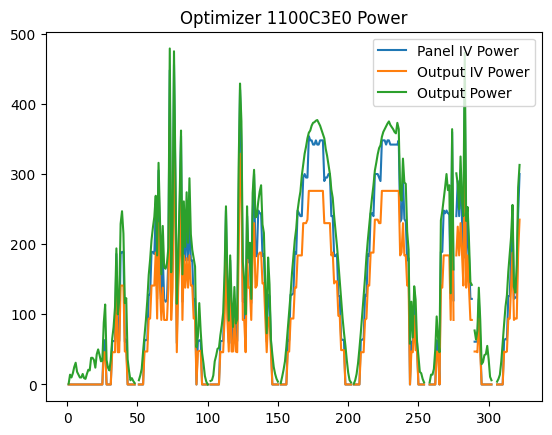

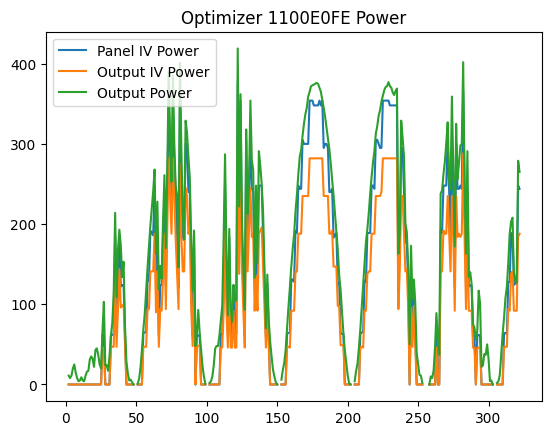

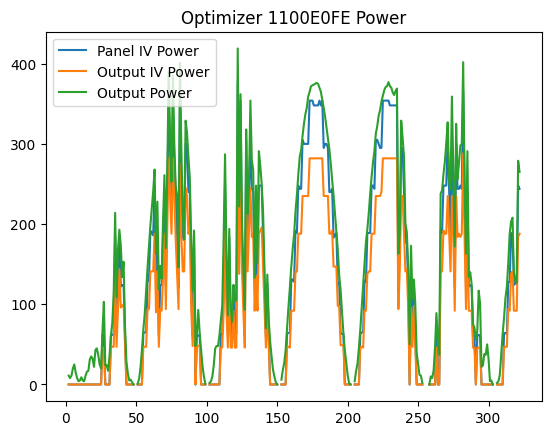

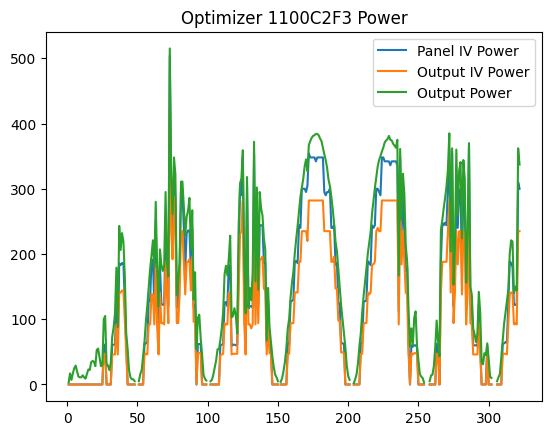

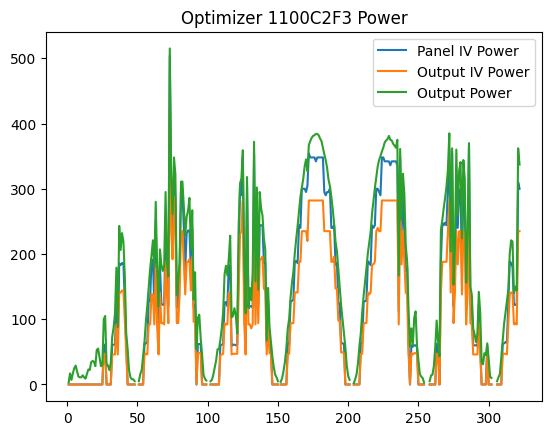

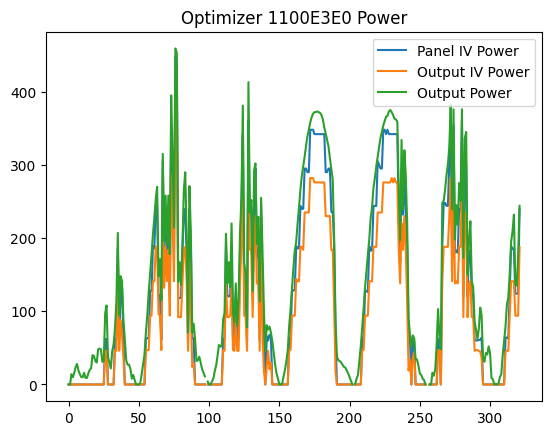

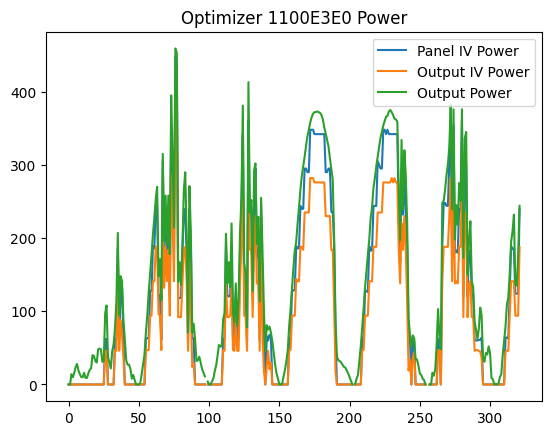

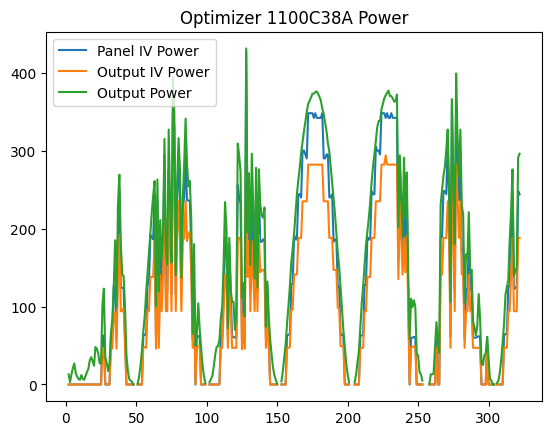

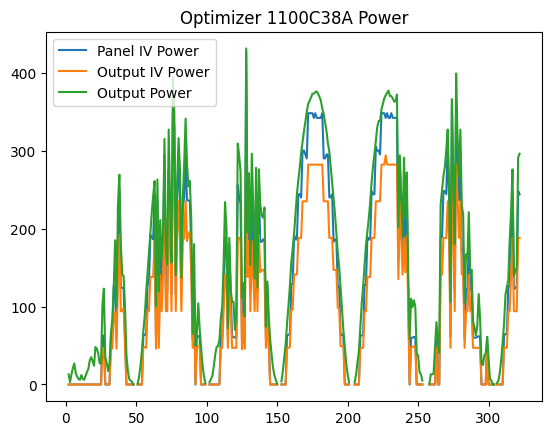

In [4]:
# Create an empty column for storing the summed power at each time step
df['Total Panel IV Power'] = 0
df['Total Output IV Power'] = 0
df['Total Output Power'] = 0

# for each optimizer id, calculate the power and sum over optimizers for each time step
for optimizer_id in optimiser_ids:
    # Panel IV power (using optimizer id)
    panel_voltage = df[f'Panel Voltage (V) - {optimizer_id}']
    panel_current = df[f'Panel Current (A) - {optimizer_id}']
    df[f'Panel IV Power - {optimizer_id}'] = panel_voltage * panel_current
    
    # Output IV power (using optimizer id)
    output_voltage = df[f'Output Voltage (V) - {optimizer_id}']
    output_current = df[f'Output Current (A) - {optimizer_id}']
    df[f'Output IV Power - {optimizer_id}'] = output_voltage * output_current

    # Sum over all optimizers for each time step
    df['Total Panel IV Power'] += df[f'Panel IV Power - {optimizer_id}']
    df['Total Output IV Power'] += df[f'Output IV Power - {optimizer_id}']
    df['Total Output Power'] += df[f'Output Power (W) - {optimizer_id}']

    # Plot the power for individual optimizers
    plt.figure()
    plt.plot(df[f'Panel IV Power - {optimizer_id}'], label='Panel IV Power')
    plt.plot(df[f'Output IV Power - {optimizer_id}'], label='Output IV Power')
    plt.plot(df[f'Output Power (W) - {optimizer_id}'], label='Output Power')
    plt.legend()
    plt.title(f'Optimizer {optimizer_id} Power')
    plt.show()

# # Plot the total summed power
# plt.figure()
# plt.plot(df['Total Panel IV Power'], label='Total Panel IV Power')
# plt.plot(df['Total Output IV Power'], label='Total Output IV Power')
# plt.legend()
# plt.title('Total Power Summed Over All Optimizers')
# plt.show()


# 3. Calculate the IV from each MPPT

## 3.1. LTSpice fit visualisation

### 3.1.1. STC

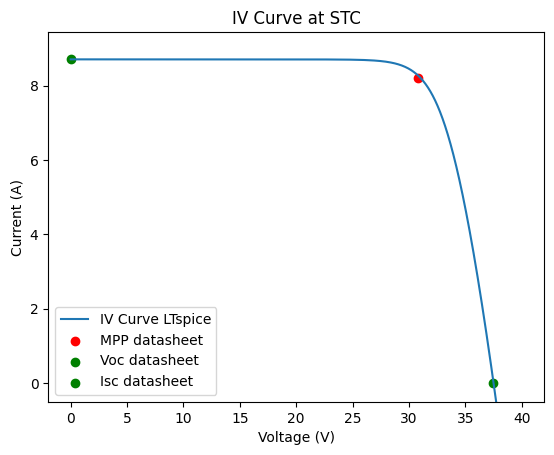

In [5]:
# define the datasheet value
Isc_stc_ds = 8.71 # A
Voc_stc_ds = 37.5 # V
Pmpp_stc_ds = 253 # W
Imppt_stc_ds = 8.21 # A
Vmppt_stc_ds = 30.8 # V

# Load the text file and rename the columns
df_stc_IV = pd.read_csv(ltspice_dir_stc, delimiter='\t')  # Assuming ltspice_dir_stc is defined with file path
df_stc_IV.rename(columns={'v1': 'Voltage', 'I(V1)': 'Current'}, inplace=True)

# Find the maximum power point (MPP)
df_stc_IV['Power'] = df_stc_IV['Voltage'] * df_stc_IV['Current']
max_power_point = df_stc_IV.loc[df_stc_IV['Power'].idxmax()]

# Record the V, I, and P at MPP
V_mpp_stc = max_power_point['Voltage']
I_mpp_stc = max_power_point['Current']
P_mpp_stc = max_power_point['Power']

# Calculate Voc and Isc
# Voc is the voltage when the current is closest to zero
Voc_stc = df_stc_IV.iloc[(df_stc_IV['Current'].abs()).idxmin()]['Voltage']
# Isc is the current when the voltage is closest to zero
Isc_stc = df_stc_IV.iloc[(df_stc_IV['Voltage'].abs()).idxmin()]['Current']

# Plot the IV curve and mark the MPP, Voc, and Isc
plt.figure()
plt.plot(df_stc_IV['Voltage'], df_stc_IV['Current'], label='IV Curve LTspice')
plt.scatter(Vmppt_stc_ds, Imppt_stc_ds, label='MPP datasheet', color='red')
plt.scatter(Voc_stc_ds, 0, label='Voc datasheet', color='green')
plt.scatter(0, Isc_stc_ds, label='Isc datasheet', color='green')
plt.legend()
plt.title('IV Curve at STC')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.ylim(bottom=-0.5)
plt.show()


### 3.1.2. NOCT

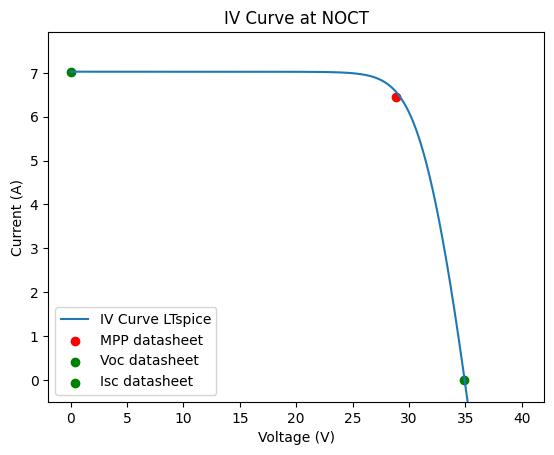

In [6]:
# Define the NOCT datasheet values
Isc_noct_ds = 7.03  # A
Voc_noct_ds = 34.9  # V
Imppt_noct_ds = 6.44  # A
Vmppt_noct_ds = 28.9  # V
Pmpp_noct_ds = 186  # W

# Load the NOCT data (assuming ltspice_dir_noct is the file path for NOCT conditions)
df_noct_IV = pd.read_csv(ltspice_dir_noct, delimiter='\t')  # Adjust ltspice_dir_noct as necessary
df_noct_IV.rename(columns={'v1': 'Voltage', 'I(V1)': 'Current'}, inplace=True)

# Find the maximum power point (MPP)
df_noct_IV['Power'] = df_noct_IV['Voltage'] * df_noct_IV['Current']
max_power_point_noct = df_noct_IV.loc[df_noct_IV['Power'].idxmax()]

# Record the V, I, and P at MPP for NOCT
V_mpp_noct = max_power_point_noct['Voltage']
I_mpp_noct = max_power_point_noct['Current']
P_mpp_noct = max_power_point_noct['Power']

# Calculate Voc and Isc for NOCT
Voc_noct = df_noct_IV.iloc[(df_noct_IV['Current'].abs()).idxmin()]['Voltage']  # Voltage when current is closest to 0
Isc_noct = df_noct_IV.iloc[(df_noct_IV['Voltage'].abs()).idxmin()]['Current']  # Current when voltage is closest to 0

# Plot the IV curve for NOCT and mark the MPP, Voc, and Isc from both simulation and datasheet
plt.figure()
plt.plot(df_noct_IV['Voltage'], df_noct_IV['Current'], label='IV Curve LTspice')
plt.scatter(Vmppt_noct_ds, Imppt_noct_ds, label='MPP datasheet', color='red')
plt.scatter(Voc_noct_ds, 0, label='Voc datasheet', color='green')
plt.scatter(0, Isc_noct_ds, label='Isc datasheet', color='green')
plt.legend()
plt.title('IV Curve at NOCT')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
plt.ylim(bottom=-0.5)  # Set the lower bound of y-axis to -0.5, let the upper bound adjust automatically
plt.show()


## 3.2. Calculate I from V

In [7]:
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Create a timestamped output directory
output_dir = os.path.join(base_dir, f'i_from_v/iv_curve_plots_{timestamp}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF and the minimum Isc values
image_files = []
min_isc_values = []

# Determine fixed x and y axis limits for all plots
x_limit = (0, Vaxis.max())
y_limit = (0, df[[f'Panel Current (A) - {optimiser}' for optimiser in optimiser_ids]].max().max() * 1.2)

# Loop through each time step
for idx in range(len(df)):

    # Create a new figure for each time step
    plt.figure(figsize=(10, 6))

    # Initialize a counter for the number of IV curves in the plot
    iv_curve_count = 0

    # Initialize a list to store the Isc values for all optimisers at this time step
    isc_values_at_step = []

    # Check if this row contains any NaN or zero
    is_nan_or_zero = df.iloc[idx].isnull().values.any() or (df.iloc[idx] == 0).values.any()
    if is_nan_or_zero:
        print(f"Time step {idx} contains NaN or zero values, plotting zero current IV curves.")

    # Loop through each optimiser
    for optimiser in optimiser_ids:
        
        # Extract the IV data from the optimiser for the current time step
        optimiser_voltage = df[f'Panel Voltage (V) - {optimiser}']
        optimiser_current = df[f'Panel Current (A) - {optimiser}']

        if is_nan_or_zero:
            # If there are NaN or zero values, set current to zero for the entire voltage range
            current = np.zeros_like(Vaxis)
            plt.plot(Vaxis, current, label=f'Optimizer {optimiser}')
            isc_optimiser = 0  # Set Isc to zero in case of NaN or zero values
        else:
            # Extract voltage and current for the current time step
            panel_voltage = optimiser_voltage.iloc[idx] / 2
            panel_current = optimiser_current.iloc[idx]

            # Calculate the I0 at the operating point for the current time step
            I0_op = I0(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth)

            # Calculate the IL at the operating point for the current time step
            IL_op = IL(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth, I0_op)

            # Use the single diode model to calculate current for each voltage point
            params = {
                'photocurrent': IL_op,  # Photocurrent (light-generated current)
                'saturation_current': I0_op,  # Saturation current
                'resistance_series': Rs_stc,  # Series resistance
                'resistance_shunt': Rsh_stc,  # Shunt resistance
                'nNsVth': n_stc * N * vth  # Ideality factor * Cells in series * Thermal voltage
            }

            # Generate a range of voltages for plotting the IV curve
            voltages = Vaxis

            # Calculate current for each voltage point using the single diode model
            current = pvlib.pvsystem.i_from_v(
                voltage=voltages,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )

            # Find the largest current value in the IV curve as Isc
            isc_optimiser = np.max(current)

            # Plot the IV curve for the current time step on the same axis
            plt.plot(voltages, current, label=f'Optimizer {optimiser}')

            # Mark the panel voltage and panel current at this point
            plt.plot(panel_voltage, panel_current, 'ro')  # Mark with a red circle

        # Store the Isc value for this optimizer
        isc_values_at_step.append(isc_optimiser)

        # Increment the counter for each plotted IV curve
        iv_curve_count += 1

    # Calculate the smallest Isc value among the optimisers for this time step
    smallest_isc = min(isc_values_at_step)
    min_isc_values.append(smallest_isc)

    # Print out the number of IV curves in the plot
    print(f"Time step {idx} has {iv_curve_count} IV curves plotted.")

    # Set consistent x and y axis limits for all plots
    plt.xlim(x_limit)
    plt.ylim(y_limit)

    # Finalize the plot for the current time step with the smallest Isc in the title
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title(f'IV Curves at Time Step {idx} - Smallest Isc: {smallest_isc:.2f} A')
    plt.grid(True)

    # Save the plot as a PNG file in the timestamped output directory
    file_path = os.path.join(output_dir, f'iv_curve_{idx}.png')
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Create a GIF from the saved images with slower speed and loop indefinitely
gif_path = os.path.join(output_dir, 'iv_curves.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as '{gif_path}'")

# Save the smallest Isc values to a DataFrame and CSV
isc_df = pd.DataFrame({'Smallest Isc': min_isc_values})

# Save the Isc values to a CSV file
isc_file = os.path.join(output_dir, 'min_isc_values.csv')
isc_df.to_csv(isc_file, index_label='Time Step')
print(f"Smallest Isc values saved as '{isc_file}'")


Time step 0 contains NaN or zero values, plotting zero current IV curves.
Time step 0 has 32 IV curves plotted.
Time step 1 contains NaN or zero values, plotting zero current IV curves.
Time step 1 has 32 IV curves plotted.
Time step 2 contains NaN or zero values, plotting zero current IV curves.
Time step 2 has 32 IV curves plotted.
Time step 3 contains NaN or zero values, plotting zero current IV curves.
Time step 3 has 32 IV curves plotted.
Time step 4 contains NaN or zero values, plotting zero current IV curves.
Time step 4 has 32 IV curves plotted.
Time step 5 contains NaN or zero values, plotting zero current IV curves.
Time step 5 has 32 IV curves plotted.
Time step 6 contains NaN or zero values, plotting zero current IV curves.
Time step 6 has 32 IV curves plotted.
Time step 7 contains NaN or zero values, plotting zero current IV curves.
Time step 7 has 32 IV curves plotted.
Time step 8 contains NaN or zero values, plotting zero current IV curves.
Time step 8 has 32 IV curves p

C:\Users\z5183876\AppData\Local\Temp\ipykernel_14684\1904732618.py:122: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\i_from_v/iv_curve_plots_20250114_093934\iv_curves.gif'
Smallest Isc values saved as 'C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\i_from_v/iv_curve_plots_20250114_093934\min_isc_values.csv'


## 3.3. Calculate V from I

In [8]:
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i/iv_curve_plots_{timestamp}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF
image_files = []

# Determine fixed x and y axis limits for all plots
# Assuming the current ranges from 0 to max possible current and voltage can range from 0 to some reasonable value
y_limit = (0, df[[f'Panel Current (A) - {optimiser}' for optimiser in optimiser_ids]].max().max() * 1)
x_limit = (0, 36)  # Assuming a reasonable range for combined voltages

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit[1], 100)

# Loop through each time step
for idx in range(len(df)):

    # Create a new figure for each time step
    plt.figure(figsize=(10, 6))

    # Initialize a counter for the number of IV curves in the plot
    iv_curve_count = 0

    # Check if this row contains any NaN or zero
    is_nan_or_zero = df.iloc[idx].isnull().values.any() or (df.iloc[idx] == 0).values.any()
    if is_nan_or_zero:
        print(f"Time step {idx} contains NaN or zero values, plotting zero voltage IV curves.")

    # Loop through each optimiser
    for optimiser in optimiser_ids:
        
        # Extract the IV data from the optimiser for the current time step
        optimiser_voltage = df[f'Panel Voltage (V) - {optimiser}']
        optimiser_current = df[f'Panel Current (A) - {optimiser}']

        if is_nan_or_zero:
            # If there are NaN or zero values, set voltage to zero for the entire current range
            voltage = np.zeros_like(currents)
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')
        else:
            # Extract voltage and current for the current time step
            panel_voltage = optimiser_voltage.iloc[idx] / 2
            panel_current = optimiser_current.iloc[idx]

            # Calculate the I0 at the operating point for the current time step
            I0_op = I0(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth)

            # Calculate the IL at the operating point for the current time step
            IL_op = IL(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth, I0_op)

            # Use the single diode model to calculate voltage for each current point
            params = {
                'photocurrent': IL_op,  # Photocurrent (light-generated current)
                'saturation_current': I0_op,  # Saturation current
                'resistance_series': Rs_stc,  # Series resistance
                'resistance_shunt': Rsh_stc,  # Shunt resistance
                'nNsVth': n_stc * N * vth  # Ideality factor * Cells in series * Thermal voltage
            }

            # Calculate voltage for each current point using the single diode model
            voltage = pvlib.pvsystem.v_from_i(
                current=currents,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )

            # Plot the IV curve for the current time step on the same axis
            plt.plot(voltage, currents, label=f'Optimizer {optimiser}')

            # Mark the panel voltage and panel current at this point
            plt.plot(panel_voltage, panel_current, 'ro')  # Mark with a red circle

        # Increment the counter for each plotted IV curve
        iv_curve_count += 1

    # Print out the number of IV curves in the plot
    print(f"Time step {idx} has {iv_curve_count} IV curves plotted.")

    # Set consistent x and y axis limits for all plots
    plt.xlim(x_limit)
    plt.ylim(y_limit)

    # Finalize the plot for the current time step
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title(f'IV Curves at Time Step {idx}')
    plt.grid(True)

    # Save the plot as a PNG file
    file_path = os.path.join(output_dir, f'iv_curve_{idx}.png')
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Create a GIF from the saved images with slower speed and loop indefinitely
gif_path = os.path.join(output_dir, 'iv_curves.gif')
with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as '{gif_path}'")


Time step 0 contains NaN or zero values, plotting zero voltage IV curves.
Time step 0 has 32 IV curves plotted.
Time step 1 contains NaN or zero values, plotting zero voltage IV curves.
Time step 1 has 32 IV curves plotted.
Time step 2 contains NaN or zero values, plotting zero voltage IV curves.
Time step 2 has 32 IV curves plotted.
Time step 3 contains NaN or zero values, plotting zero voltage IV curves.
Time step 3 has 32 IV curves plotted.
Time step 4 contains NaN or zero values, plotting zero voltage IV curves.
Time step 4 has 32 IV curves plotted.
Time step 5 contains NaN or zero values, plotting zero voltage IV curves.
Time step 5 has 32 IV curves plotted.
Time step 6 contains NaN or zero values, plotting zero voltage IV curves.
Time step 6 has 32 IV curves plotted.
Time step 7 contains NaN or zero values, plotting zero voltage IV curves.
Time step 7 has 32 IV curves plotted.
Time step 8 contains NaN or zero values, plotting zero voltage IV curves.
Time step 8 has 32 IV curves p

C:\Users\z5183876\AppData\Local\Temp\ipykernel_14684\671894746.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i/iv_curve_plots_20250114_094053\iv_curves.gif'


# 4. Combine the IV

## 4.1. Without current clipping

In [9]:
# Ensure the output directory exists
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF
image_files = []

# DataFrame to store the maximum power points at each time step
max_power_df = pd.DataFrame(columns=['Time Step', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])

# Determine fixed x and y axis limits for all plots
y_limit = (0, df[[f'Panel Current (A) - {optimiser}' for optimiser in optimiser_ids]].max().max() * 1)
x_limit = (0, 36 * 32)  # Adjust for combined voltages

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit[1], 100)

# Debug: Print the output directory
print(f"Output directory: {output_dir}")

# Loop through each time step
for idx in range(len(df)):

    # Create a new figure for each time step
    plt.figure(figsize=(10, 6))

    # Initialize array to store summed voltages for combined IV curve
    combined_voltage = np.zeros_like(currents)
    max_power = 0  # Initialize max power as 0 for each step

    # Check if this row contains any NaN or zero
    is_nan_or_zero = df.iloc[idx].isnull().values.any() or (df.iloc[idx] == 0).values.any()
    if is_nan_or_zero:
        print(f"Time step {idx} contains NaN or zero values, skipping combined IV curve.")
        zero_power = pd.DataFrame({
            'Time Step': [idx],
            'Max Voltage (V)': [0],
            'Max Current (A)': [0],
            'Max Power (W)': [0],
            'Voc (V)': [0],  
            'Isc (A)': [0]   
        })
        max_power_df = pd.concat([max_power_df, zero_power], ignore_index=True)
        continue

    # Loop through each optimiser
    for optimiser in optimiser_ids:
        # Extract the IV data from the optimiser for the current time step
        optimiser_voltage = df[f'Panel Voltage (V) - {optimiser}']
        optimiser_current = df[f'Panel Current (A) - {optimiser}']

        if is_nan_or_zero:
            continue
        else:
            panel_voltage = optimiser_voltage.iloc[idx] / 2
            panel_current = optimiser_current.iloc[idx]

            # Check if panel_voltage and panel_current contain valid values
            if np.isnan(panel_voltage) or np.isnan(panel_current):
                print(f"NaN found in voltage/current at time step {idx}, optimiser {optimiser}")
                continue

            # Here, calculate I0_op, IL_op, etc.

            # Calculate the I0 at the operating point for the current time step
            I0_op = I0(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth)

            # Calculate the IL at the operating point for the current time step
            IL_op = IL(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth, I0_op)

            # Use the single diode model to calculate voltage for each current point
            params = {
                'photocurrent': IL_op,  # Photocurrent (light-generated current)
                'saturation_current': I0_op,  # Saturation current
                'resistance_series': Rs_stc,  # Series resistance
                'resistance_shunt': Rsh_stc,  # Shunt resistance
                'nNsVth': n_stc * N * vth  # Ideality factor * Cells in series * Thermal voltage
            }

            # Calculate voltage for each current point using the single diode model
            voltage = pvlib.pvsystem.v_from_i(
                current=currents,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )

            # Add the voltage to the combined voltage array
            combined_voltage += voltage

            # Calculate power for each voltage point using the single diode model
            power = voltage * currents


    # Check if the combined_voltage or power has NaN values
    if np.isnan(combined_voltage).any() or np.isnan(power).any():
        print(f"NaN detected in combined_voltage or power at time step {idx}. Skipping this step.")
        continue

    # Find the index of the maximum power point
    max_power_idx = np.argmax(power)
    max_voltage = combined_voltage[max_power_idx]
    max_current = currents[max_power_idx]
    max_power = power[max_power_idx]

    # Voc and Isc calculation
    Voc = combined_voltage[-1]
    Isc = currents[0]

    # Create a DataFrame for the current max power point
    max_power_point = pd.DataFrame({
        'Time Step': [idx],
        'Max Voltage (V)': [max_voltage],
        'Max Current (A)': [max_current],
        'Max Power (W)': [max_power],
        'Voc (V)': [Voc],
        'Isc (A)': [Isc]
    })

    max_power_df = pd.concat([max_power_df, max_power_point], ignore_index=True)

    # Plot the combined IV curve
    plt.plot(combined_voltage, currents, label='Combined IV Curve')
    plt.plot(max_voltage, max_current, 'ro', label='Max Power Point')

    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title(f'Combined IV Curves at Time Step {idx}')
    plt.grid(True)
    plt.legend()

    # Debug: Print the file path where the image will be saved
    file_path = os.path.join(output_dir, f'combined_iv_curve_{idx}.png')
    print(f"Saving image to: {file_path}")

    # Save the plot as a PNG file
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Debug: Check if images were saved
print(f"Image files list: {image_files}")

# Save the DataFrame to a CSV file
csv_file = os.path.join(output_dir, 'max_power_points_with_voc_isc.csv')
max_power_df.to_csv(csv_file, index=False)
print(f"CSV saved as: {csv_file}")

# Debug: Print the GIF creation process
gif_path = os.path.join(output_dir, 'combined_iv_curves.gif')
print(f"Creating GIF at: {gif_path}")

with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        try:
            image = imageio.imread(filename)
            writer.append_data(image)
            print(f"Added {filename} to GIF")
        except Exception as e:
            print(f"Error adding {filename} to GIF: {e}")

print(f"GIF saved as: {gif_path}")


Output directory: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231
Time step 0 contains NaN or zero values, skipping combined IV curve.
Time step 1 contains NaN or zero values, skipping combined IV curve.
Time step 2 contains NaN or zero values, skipping combined IV curve.
Time step 3 contains NaN or zero values, skipping combined IV curve.
Time step 4 contains NaN or zero values, skipping combined IV curve.
Time step 5 contains NaN or zero values, skipping combined IV curve.
Time step 6 contains NaN or zero values, skipping combined IV curve.
Time step 7 contains NaN or zero values, skipping combined IV curve.
Time step 8 contains NaN or zero values, skipping combined IV curve.
Time step 9 contains NaN or zero values, skipping combined IV curve.
Time step 10 contains NaN or zero values, skipping combined IV curve.
Time step 11 contains NaN or zero values, skipping combined IV curve.
Time step 12 contains NaN or zero values, 

C:\Users\z5183876\AppData\Local\Temp\ipykernel_14684\3731837300.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_26.png
Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_27.png
Time step 28 contains NaN or zero values, skipping combined IV curve.
Time step 29 contains NaN or zero values, skipping combined IV curve.
Time step 30 contains NaN or zero values, skipping combined IV curve.
Time step 31 contains NaN or zero values, skipping combined IV curve.
Time step 32 contains NaN or zero values, skipping combined IV curve.
Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_33.png
Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_34.png
Saving image to: C:\Users\z5183876\Documen

C:\Users\z5183876\AppData\Local\Temp\ipykernel_14684\3731837300.py:164: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_34.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_35.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_36.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_37.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_38.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094231\combined_iv_curve_39.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

## 4.2. Current clipping

In [10]:
# Get the current timestamp when the code is run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = os.path.join(base_dir, f'v_from_i_combined/iv_curve_plots_{timestamp}')
os.makedirs(output_dir, exist_ok=True)

# List to keep track of file paths for the GIF
image_files = []

# DataFrame to store the maximum power points at each time step
max_power_df_clip_i = pd.DataFrame(columns=['Time Step', 'Max Voltage (V)', 'Max Current (A)', 'Max Power (W)', 'Voc (V)', 'Isc (A)'])

# Determine fixed x and y axis limits for all plots
y_limit = (0, df[[f'Panel Current (A) - {optimiser}' for optimiser in optimiser_ids]].max().max() * 1)
x_limit = (0, 36 * 32)  # Adjust for combined voltages

# Generate a range of currents for plotting the IV curve
currents = np.linspace(0, y_limit[1], 100)

# Debug: Print the output directory
print(f"Output directory: {output_dir}")

# Loop through each time step
for idx in range(len(df)):

    # Create a new figure for each time step
    plt.figure(figsize=(10, 6))

    # Initialize array to store summed voltages for combined IV curve
    combined_voltage = np.zeros_like(currents)
    max_power = 0  # Initialize max power as 0 for each step

    # Check if this row contains any NaN or zero
    is_nan_or_zero = df.iloc[idx].isnull().values.any() or (df.iloc[idx] == 0).values.any()
    if is_nan_or_zero:
        print(f"Time step {idx} contains NaN or zero values, skipping combined IV curve.")
        zero_power = pd.DataFrame({
            'Time Step': [idx],
            'Max Voltage (V)': [0],
            'Max Current (A)': [0],
            'Max Power (W)': [0],
            'Voc (V)': [0],  
            'Isc (A)': [0]   
        })
        max_power_df_clip_i = pd.concat([max_power_df_clip_i, zero_power], ignore_index=True)
        continue

    # Get the smallest Isc value from isc_df for the current time step across all optimisers
    smallest_isc = isc_df.loc[idx].values

    # Loop through each optimiser
    for optimiser in optimiser_ids:
        # Extract the IV data from the optimiser for the current time step
        optimiser_voltage = df[f'Panel Voltage (V) - {optimiser}']
        optimiser_current = df[f'Panel Current (A) - {optimiser}']

        if is_nan_or_zero:
            continue
        else:
            panel_voltage = optimiser_voltage.iloc[idx] / 2
            panel_current = optimiser_current.iloc[idx]

            # Check if panel_voltage and panel_current contain valid values
            if np.isnan(panel_voltage) or np.isnan(panel_current):
                print(f"NaN found in voltage/current at time step {idx}, optimiser {optimiser}")
                continue

            # Calculate I0 and IL for the optimiser at this time step
            I0_op = I0(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth)
            IL_op = IL(panel_current, panel_voltage, Rs_stc, Rsh_stc, n_stc, N, vth, I0_op)

            # Use the single diode model to calculate voltage for each current point
            params = {
                'photocurrent': IL_op,  # Photocurrent (light-generated current)
                'saturation_current': I0_op,  # Saturation current
                'resistance_series': Rs_stc,  # Series resistance
                'resistance_shunt': Rsh_stc,  # Shunt resistance
                'nNsVth': n_stc * N * vth  # Ideality factor * Cells in series * Thermal voltage
            }

            # Calculate voltage for each current point using the single diode model
            voltage = pvlib.pvsystem.v_from_i(
                current=currents,
                photocurrent=params['photocurrent'],
                saturation_current=params['saturation_current'],
                resistance_series=params['resistance_series'],
                resistance_shunt=params['resistance_shunt'],
                nNsVth=params['nNsVth']
            )

            # If current > smallest Isc, set voltage to 0 for those current values
            voltage = np.where(currents > smallest_isc, 0, voltage)

            # Add the voltage to the combined voltage array
            combined_voltage += voltage

    # Calculate power for each voltage point using the combined IV curve
    power = combined_voltage * currents

    # Check if the combined_voltage or power has NaN values
    if np.isnan(combined_voltage).any() or np.isnan(power).any():
        print(f"NaN detected in combined_voltage or power at time step {idx}. Skipping this step.")
        continue

    # Find the index of the maximum power point
    max_power_idx = np.argmax(power)
    max_voltage = combined_voltage[max_power_idx]
    max_current = currents[max_power_idx]
    max_power = power[max_power_idx]

    # Voc and Isc calculation
    Voc = combined_voltage[-1]
    Isc = smallest_isc  # Use the smallest Isc value for this time step

    # Create a DataFrame for the current max power point
    max_power_point = pd.DataFrame({
        'Time Step': [idx],
        'Max Voltage (V)': [max_voltage],
        'Max Current (A)': [max_current],
        'Max Power (W)': [max_power],
        'Voc (V)': [Voc],
        'Isc (A)': [Isc]
    })

    max_power_df_clip_i = pd.concat([max_power_df_clip_i, max_power_point], ignore_index=True)

    # Plot the combined IV curve
    plt.plot(combined_voltage, currents, label='Combined IV Curve')
    plt.plot(max_voltage, max_current, 'ro', label='Max Power Point')

    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.xlabel('Voltage (V)')
    plt.ylabel('Current (A)')
    plt.title(f'Combined IV Curves at Time Step {idx}')
    plt.grid(True)
    plt.legend()

    # Debug: Print the file path where the image will be saved
    file_path = os.path.join(output_dir, f'combined_iv_curve_{idx}.png')
    print(f"Saving image to: {file_path}")

    # Save the plot as a PNG file
    plt.savefig(file_path)
    plt.close()

    # Add the file path to the list for GIF creation
    image_files.append(file_path)

# Debug: Check if images were saved
print(f"Image files list: {image_files}")

# Save the DataFrame to a CSV file
csv_file = os.path.join(output_dir, 'max_power_points_with_voc_isc.csv')
max_power_df_clip_i.to_csv(csv_file, index=False)
print(f"CSV saved as: {csv_file}")

# Debug: Print the GIF creation process
gif_path = os.path.join(output_dir, 'combined_iv_curves.gif')
print(f"Creating GIF at: {gif_path}")

with imageio.get_writer(gif_path, mode='I', duration=200, loop=0) as writer:
    for filename in image_files:
        try:
            image = imageio.imread(filename)
            writer.append_data(image)
            print(f"Added {filename} to GIF")
        except Exception as e:
            print(f"Error adding {filename} to GIF: {e}")

print(f"GIF saved as: {gif_path}")


Output directory: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329
Time step 0 contains NaN or zero values, skipping combined IV curve.
Time step 1 contains NaN or zero values, skipping combined IV curve.
Time step 2 contains NaN or zero values, skipping combined IV curve.
Time step 3 contains NaN or zero values, skipping combined IV curve.
Time step 4 contains NaN or zero values, skipping combined IV curve.
Time step 5 contains NaN or zero values, skipping combined IV curve.
Time step 6 contains NaN or zero values, skipping combined IV curve.
Time step 7 contains NaN or zero values, skipping combined IV curve.
Time step 8 contains NaN or zero values, skipping combined IV curve.
Time step 9 contains NaN or zero values, skipping combined IV curve.
Time step 10 contains NaN or zero values, skipping combined IV curve.
Time step 11 contains NaN or zero values, skipping combined IV curve.
Time step 12 contains NaN or zero values, 

C:\Users\z5183876\AppData\Local\Temp\ipykernel_14684\3409293106.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_27.png
Time step 28 contains NaN or zero values, skipping combined IV curve.
Time step 29 contains NaN or zero values, skipping combined IV curve.
Time step 30 contains NaN or zero values, skipping combined IV curve.
Time step 31 contains NaN or zero values, skipping combined IV curve.
Time step 32 contains NaN or zero values, skipping combined IV curve.
Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_33.png
Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_34.png
Saving image to: C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_35.png
Saving image to: C:\Users\z5183876\Documen

C:\Users\z5183876\AppData\Local\Temp\ipykernel_14684\3409293106.py:164: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_60.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_61.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_62.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_63.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_64.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094329\combined_iv_curve_65.png to GIF
Added C:\Users\z5183876\Documents\GitHub\24_09_24_Mismatch\Results\v_from_i_combined/iv_curve_plots_20250114_094

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

# 5. Power comparison

## 5.1. Store the power

In [11]:
# define which combined power to use
df_no_opt = max_power_df_clip_i
# df_no_opt = df_max_power

# Rename the Max Power (W) as 'Max Power (W) - without optimiser'
df_no_opt.rename(columns={'Max Power (W)': 'Max Power (W) - without optimiser'}, inplace=True)

# merge the two dataframes
df_combined = pd.merge(df, df_no_opt, how='inner', left_index=True, right_index=True)

# only keep the columns 'Total Panel IV Power', 'Total Output IV Power', 'Total Output Power', 'Max Power (W) - without optimiser'
df_combined = df_combined[['Total Panel IV Power', 'Total Output IV Power', 'Total Output Power', 'Max Power (W) - without optimiser']]

# export it as csv file to the base directory
df_combined.to_csv(os.path.join(base_dir, 'power_data.csv'), index=False)

## 5.2. Power visualisation

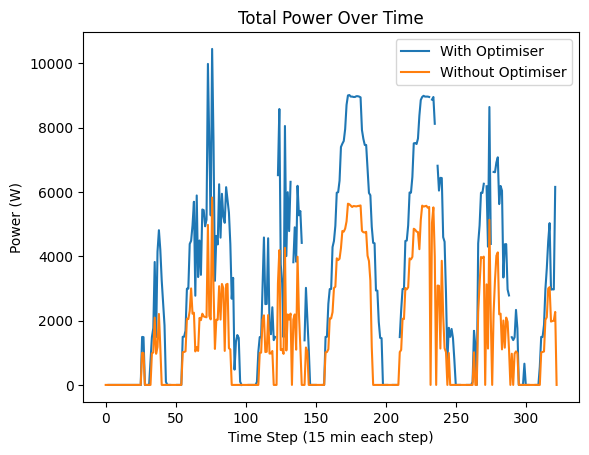

In [12]:
# read the power csv file
df_power = pd.read_csv(os.path.join(base_dir, 'power_data.csv'))

# Plot the total power over time
plt.figure()
# plt.plot(df['Total Panel IV Power'], label='Total Panel IV Power')
plt.plot(df_power['Total Output IV Power'], label='Total Output IV Power')
# plt.plot(df['Total Output Power'], label='Total Output Power')
plt.plot(df_power['Max Power (W) - without optimiser'], label='Max Power (W) - without optimiser')
plt.legend()
plt.title('Total Power Over Time')
# change the ledgends to show the correct names
plt.legend(['With Optimiser', 'Without Optimiser'])
plt.ylabel('Power (W)')
plt.xlabel('Time Step (15 min each step)')
plt.show()

## 5.3. Filtering & percentage difference

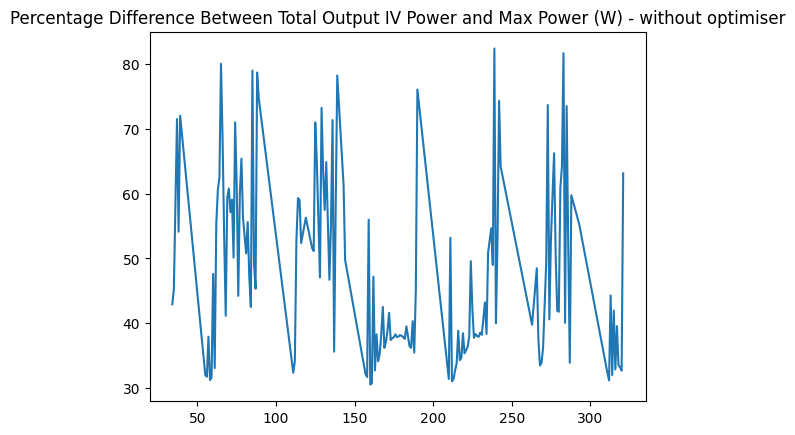

Total power difference as a percentage: 47.14%


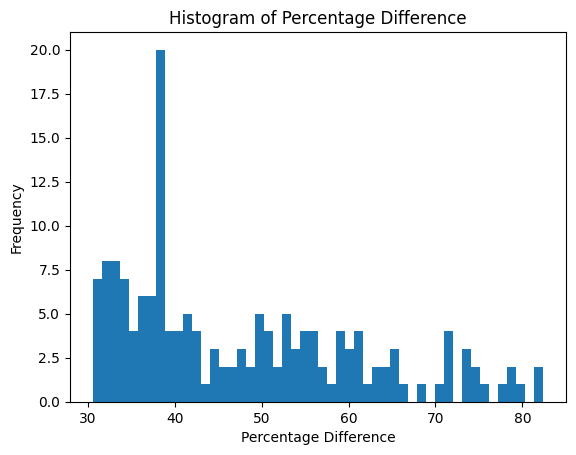

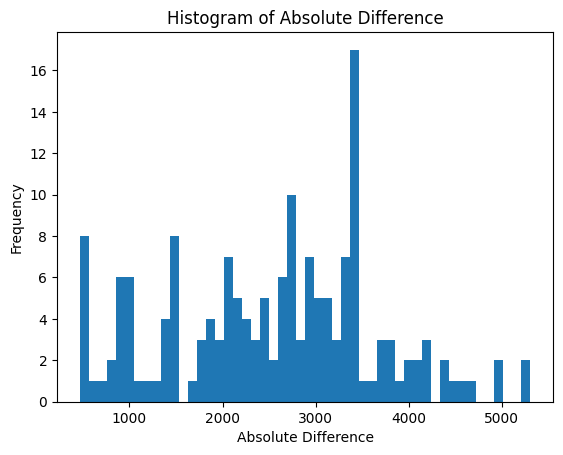

In [13]:
# only keep the data when the Max Power (W) - without optimiser is greater than 1000
df_power = df_power[df_power['Max Power (W) - without optimiser'] > 1000]

# select two parameter to compare
# param1 = 'Total Output IV Power'
param1 = 'Total Output IV Power'
param2 = 'Max Power (W) - without optimiser'

# calculate the percentage difference between the two
df_power['Percentage Difference'] = (df_power[param1] - df_power[param2]) / df_power[param1] * 100

# plot the percentage difference
plt.figure()
plt.plot(df_power['Percentage Difference'])
plt.title('Percentage Difference Between Total Output IV Power and Max Power (W) - without optimiser')
plt.show()

# calculate the sum of the power difference as a percentage
power_diff_sum = (df_power[param1].sum() - df_power[param2].sum())/ df_power[param1].sum() * 100
print(f"Total power difference as a percentage: {power_diff_sum:.2f}%")

# plot as a histogram
plt.figure()
plt.hist(df_power['Percentage Difference'], bins=50)
plt.title('Histogram of Percentage Difference')
plt.xlabel('Percentage Difference')
plt.ylabel('Frequency')
plt.show()

# plot the aboslute difference as a histogram
plt.figure()
plt.hist(df_power[param1] - df_power[param2], bins=50)
plt.title('Histogram of Absolute Difference')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.show()
